<a href="https://colab.research.google.com/github/x23425237/DeepLearning_GenAI/blob/main/JPM_LSTM_GRU_PredictTomorrow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

JP-Morgan - Daily Stock price Analysis and LSTM
1. Fetch data through api
2.scale the features and target - minmax scalar
3.perform data pre-processing
4.split data train and test 80/20
5.Perform LSTM- 2 layers
6.Perform LSTM-1 layer
7.Perform LSTM-1 layer(activation=relu)
8.Perform GRU-1 layer
9.Record test and validation loss
10.Record model accuracy metrics
11.Predict the closing price for next day.



In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,RepeatVector,TimeDistributed
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
import tensorflow as tf
from tensorflow.keras import layers

set_seed(455)
np.random.seed(455)

In [ ]:
# get data from api  Alpha Vantage Stock API
# G2DBRN7KCM4QHZWY
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=JPM&interval=5min&outputsize=full&apikey=G2DBRN7KCM4QHZWY'
r = requests.get(url)
data = r.json()

print(data)




In [ ]:
time_series = data.get('Time Series (5min)', {})
df=pd.DataFrame.from_dict(time_series,orient='index')

df['1. open'] = df['1. open'].astype(float)
df['2. high'] = df['2. high'].astype(float)
df['3. low'] = df['3. low'].astype(float)
df['4. close'] = df['4. close'].astype(float)
df['5. volume'] = df['5. volume'].astype(int)


In [ ]:
df.head()

,1. open,2. high,3. low,4. close,5. volume
2025-04-07 19:55:00,216.5800,217.03,216.4465,217.0100,1400
2025-04-07 19:50:00,216.4400,216.70,216.4400,216.4401,305
2025-04-07 19:45:00,216.6900,216.70,216.6900,216.7000,355
2025-04-07 19:40:00,216.7062,216.95,216.6900,216.7000,2319
2025-04-07 19:35:00,216.7500,217.00,216.7001,216.9100,517


In [ ]:
# rename the columns
dict = {'1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. volume': 'Volume'
        }
df.rename(columns=dict,
          inplace=True)

display(df)


,Open,High,Low,Close,Volume
2025-04-07 19:55:00,216.5800,217.0300,216.4465,217.0100,1400
2025-04-07 19:50:00,216.4400,216.7000,216.4400,216.4401,305
2025-04-07 19:45:00,216.6900,216.7000,216.6900,216.7000,355
2025-04-07 19:40:00,216.7062,216.9500,216.6900,216.7000,2319
2025-04-07 19:35:00,216.7500,217.0000,216.7001,216.9100,517
...,...,...,...,...,...
2025-03-10 04:20:00,238.6312,238.6312,238.4624,238.6213,38
2025-03-10 04:15:00,238.8796,238.8796,238.5915,238.5915,94
2025-03-10 04:10:00,238.8796,238.8796,238.8796,238.8796,1
2025-03-10 04:05:00,238.8796,238.8796,238.6114,238.6114,2


In [ ]:
df.head()

,Open,High,Low,Close,Volume
2025-04-07 19:55:00,216.5800,217.03,216.4465,217.0100,1400
2025-04-07 19:50:00,216.4400,216.70,216.4400,216.4401,305
2025-04-07 19:45:00,216.6900,216.70,216.6900,216.7000,355
2025-04-07 19:40:00,216.7062,216.95,216.6900,216.7000,2319
2025-04-07 19:35:00,216.7500,217.00,216.7001,216.9100,517


In [ ]:
#re-set index to rename column
reset_index=df.reset_index()
reset_index.rename(columns={'index': 'DateTime'}, inplace=True)

# change dateime object to datetime
reset_index['DateTime'] = pd.to_datetime(reset_index['DateTime'])

reset_index.head()


,DateTime,Open,High,Low,Close,Volume
0,2025-04-07 19:55:00,216.5800,217.03,216.4465,217.0100,1400
1,2025-04-07 19:50:00,216.4400,216.70,216.4400,216.4401,305
2,2025-04-07 19:45:00,216.6900,216.70,216.6900,216.7000,355
3,2025-04-07 19:40:00,216.7062,216.95,216.6900,216.7000,2319
4,2025-04-07 19:35:00,216.7500,217.00,216.7001,216.9100,517


In [ ]:
# Extract the relevant features (here we assume we're using 'Close' to predict 'Close')
features = reset_index[['Open', 'High', 'Low', 'Volume']].values
target = reset_index['Close'].values

In [ ]:
# Normalize the feature data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
features_scaled = scaler.fit_transform(features)

In [ ]:
# Normalize the target variable (Closing Price)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaled = target_scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
# Prepare the data for time-series prediction (X = features, y = target)
X = []
y = []

# we are telling the model to look back 60 datapoints to predict next day's closing price.
# values tested for 3 and 60

sequence_length =60 #3#60#180 # Number of previous time steps to consider for prediction

for i in range(sequence_length, len(features_scaled)):
    X.append(features_scaled[i-sequence_length:i])  # Take the last `sequence_length` data points
    y.append(target_scaled[i])  # The corresponding closing price

In [ ]:
from sklearn.model_selection import train_test_split
X = np.array(X) # convert list to numpy array
y = np.array(y)

# Split the data into training and testing sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# LSTM - 2 layers
#model = Sequential()



#model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) # Uses tanh by default for the activation function
#model.add(LSTM(units=50))
#model.add(Dropout(0.2)) #20% of neurons will be droppedout or set to 0

In [ ]:
#LSTM - 1 layers
#model = Sequential()


#model.add(LSTM(units=50,input_shape=(X_train.shape[1], X_train.shape[2]))) # Uses tanh by default for the activation function
#model.add(Dropout(0.2)) #20% of neurons will be droppedout or set to 0


In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
#LSTM - 1 layers - relu
#model = Sequential()


#model.add(LSTM(units=50,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) # Uses tanh by default for the activation function
#model.add(Dropout(0.2)) #20% of neurons will be droppedout or set to 0

In [ ]:
#GRU - one layer
model = Sequential()


model.add(GRU(units=50, input_shape=(X_train.shape[1], X_train.shape[2]))) # Uses tanh by default for the activation function
model.add(Dropout(0.2)) #20% of neurons will be droppedout or set to 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
print(X_train.shape)
print(y_train.shape) # 3241 in y train which is a good porting of training
print(X_test.shape)
print(y_test.shape)# 811 points in y-test

(3093, 60, 4)
(3093, 1)
(774, 60, 4)
(774, 1)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Add a Dense layer to get the output prediction
model.add(Dense(units=1))



# Compile the model
#model.compile(optimizer=Adam(learning_rate=0.01),  metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

In [ ]:
#Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           8,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,451 (33.01 KB)

 Trainable params: 8,451 (33.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history=model.fit(X_train, y_train, epochs=20, batch_size=30,validation_data=(X_test, y_test))

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.1865 - val_loss: 0.0165
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0505 - val_loss: 0.0143
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0350 - val_loss: 0.0121
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0313 - val_loss: 0.0108
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0281 - val_loss: 0.0105
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0257 - val_loss: 0.0116
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0242 - val_loss: 0.0103
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0253 - val_loss: 0.0110
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0232 - val_loss: 0.0107
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0238 - val_loss: 0.0129
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0228 - val_loss: 0.0082
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


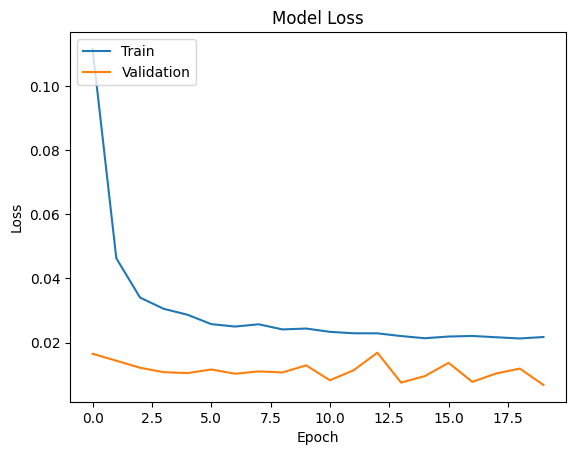

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the performance of your LSTM model:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Predict on the test set
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Mean Absolute Error (MAE): 0.006791979299004782
Mean Squared Error (MSE): 0.0005134210139185839
Root Mean Squared Error (RMSE): 0.02265879550899791


In [ ]:
# Invert scaling for the actual and predicted closing prices
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = target_scaler.inverse_transform(y_pred)

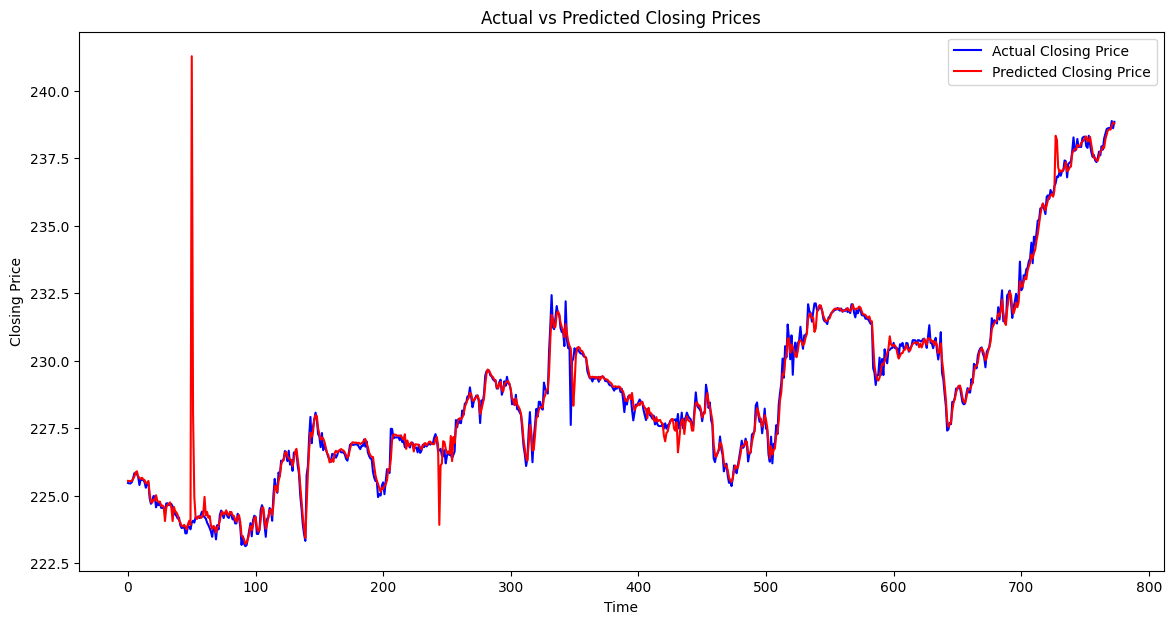

In [ ]:
# Plotting Actual vs Predicted closing prices
plt.figure(figsize=(14, 7))

# Plot actual closing prices
plt.plot(y_test_rescaled, color='blue', label='Actual Closing Price')

# Plot predicted closing prices
plt.plot(y_pred_rescaled, color='red', label='Predicted Closing Price')

plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
y_pred_rescaled[749]

array([238.15324], dtype=float32)

In [ ]:

X_input = reset_index.iloc[-sequence_length:][['Open', 'High', 'Low', 'Volume']].values
X_input = scaler.fit_transform(X_input)
X_input = np.reshape(X_input, (1, sequence_length, 4))
print("Shape of X_input :", X_input.shape)

# Show the transformed `X_input`
X_input

Shape of X_input : (1, 60, 4)


array([[[-8.75842484e-01, -1.00000000e+00, -1.00000000e+00,
         -2.20901218e-01],
        [-8.53275275e-01, -8.66326843e-01, -7.56310680e-01,
         -8.59092911e-01],
        [-7.32942067e-01, -8.66326843e-01, -8.12161472e-01,
         -8.81109643e-01],
        [-9.05944718e-01, -8.30726883e-01, -7.61420542e-01,
         -2.57595773e-01],
        [-1.00000000e+00, -8.73463146e-01, -7.66479305e-01,
          6.51548510e-01],
        [-7.55509277e-01, -8.29870527e-01, -8.21614716e-01,
          8.46469984e-01],
        [-7.66792881e-01, -7.32612907e-01, -5.63413388e-01,
          1.00000000e+00],
        [-7.74290042e-01, -7.97451320e-01, -4.66990291e-01,
         -7.28753853e-01],
        [-7.47974252e-01, -6.88082373e-01, -4.72049055e-01,
          7.41230001e-02],
        [-6.99091253e-01, -7.48842899e-01, -4.71997956e-01,
         -4.42536328e-01],
        [-7.55509277e-01, -7.77184219e-01, -5.58354624e-01,
         -3.63276090e-01],
        [-5.29799318e-01, -6.27321847e-01, 

In [ ]:
LSTM_1_prediction = model.predict(X_input)
y_pred_rescaled_simplernn = target_scaler.inverse_transform(LSTM_1_prediction)

print(y_pred_rescaled_simplernn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[254.23611]]
